In [234]:
import os, sys, time

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, Function

import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchvision.datasets.folder import find_classes, make_dataset

import pylab
import matplotlib.pyplot as plt

from scipy.misc import imread, imresize
from scipy.stats import pearsonr

from invert import invert

from indexdata import load_image_to_label
from indexdataset import load_image_dataset_label_index
from voclabels import voc_labels

import loadseg
import expdir
import intersect
import upsample
from labelprobe import cached_memmap

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [235]:
gpu = 1

cuda = True if gpu is not None else False
use_mult_gpu = isinstance(gpu, list)
if cuda:
    if use_mult_gpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu).strip('[').strip(']')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = '%d' % gpu
print(torch.cuda.device_count(), use_mult_gpu, cuda)

(1L, False, True)


In [326]:
#directory='/scratch/shared/slow/ruthfong/pytorch_alexnet_imagenet12/val'
#directory='/scratch/shared/slow/ruthfong/pytorch_alexnet_imagenet10train'
directory='/scratch/shared/slow/ruthfong/pytorch_alexnet_imagenet'
#split='train'
assert(os.path.exists(directory))
blob = 'features.11'

In [327]:
blob_names = {
    'features.1': 'relu1',
    'features.4': 'relu2',
    'features.7': 'relu3',
    'features.9': 'relu4',
    'features.11': 'relu5',
    'features': 'pool5'
}

In [328]:
ed = expdir.ExperimentDirectory(directory)

In [333]:
info = ed.load_info()
dataset = info.dataset
blob_info = ed.load_info(blob=blob)
shape = blob_info.shape

K = shape[1]

if 'broden' in info.dataset:
    ds = loadseg.SegmentationData(info.dataset)
    L = ds.label_size()
    label_names = np.array([ds.label[i]['name'] for i in range(L)])
elif 'imagenet' in info.dataset or 'ILSVRC' in info.dataset:
    L = 1000
    labels_desc = np.loadtxt('/users/ruthfong/imagenet10_synsets.txt')
    label_names = np.array([' '.join(labels_desc[label_i].split(',')[0].split()[1:]) for label_i in range(L)])

In [331]:
suffix = '_train'
probs = ed.open_mmap(blob=blob, part='act_probs%s' % suffix, mode='r', dtype='float32', shape=(L,K))

In [335]:
from word2vec.wordvectors import WordVectors

norm_weights = np.array([np.true_divide(probs[i],np.linalg.norm(probs[i])) for i in range(L)])
wv = WordVectors(vocab=label_names, vectors=norm_weights)

In [336]:
#grass, green; sky, blue
indexes, metrics = wv.analogy(pos=['grass','blue-c'], neg=['green-c'], n=10)
wv.generate_response(indexes, metrics).tolist()

[(u'tree', 0.3332693874835968),
 (u'fence', 0.3332456946372986),
 (u'water', 0.3331747055053711),
 (u'sky', 0.3331700563430786),
 (u'house', 0.33306825160980225),
 (u'earth', 0.3330627977848053),
 (u'building', 0.3330354392528534),
 (u'pole', 0.33303403854370117),
 (u'plant', 0.33301958441734314),
 (u'roof', 0.333014577627182)]

In [337]:
indexes, metrics = wv.analogy(pos=['grass'], neg=['green-c'], n=10)
wv.generate_response(indexes, metrics).tolist()

[(u'field-wild-s', 0.005707165226340294),
 (u'forest-broadleaf-s', 0.005205587949603796),
 (u'lake-artificial-s', 0.004885248374193907),
 (u'corn_field-s', 0.004806548822671175),
 (u'hill-s', 0.004625838715583086),
 (u'field-cultivated-s', 0.004602818749845028),
 (u'bog-s', 0.004359053447842598),
 (u'river-s', 0.004252123646438122),
 (u'valley-s', 0.004118820186704397),
 (u'lawn-s', 0.003945296164602041)]

In [338]:
indexes, metrics = wv.analogy(pos=['basketball hoop'], neg=['ball'], n=10)
wv.generate_response(indexes, metrics).tolist()

[(u'lined', 0.006644482724368572),
 (u'banded', 0.005993620026856661),
 (u'grid', 0.0055059874430298805),
 (u'grooved', 0.005155009217560291),
 (u'field-cultivated-s', 0.004298991523683071),
 (u'lake-artificial-s', 0.004271270241588354),
 (u'wheat_field-s', 0.0042299614287912846),
 (u'football_field-s', 0.004224580712616444),
 (u'industrial_park-s', 0.0041656470857560635),
 (u'tennis court', 0.004012712277472019)]

In [339]:
indexes, metrics = wv.analogy(pos=['horse-drawn carriage', 'baby buggy'], neg=['horse'], n=10)
wv.generate_response(indexes, metrics).tolist()

[(u'wheel', 0.3334251642227173),
 (u'headlight', 0.3334176540374756),
 (u'bicycle', 0.33338499069213867),
 (u'umbrella', 0.3332960903644562),
 (u'minibike', 0.33328479528427124),
 (u'banner', 0.3332476019859314),
 (u'flag', 0.33323314785957336),
 (u'signboard', 0.3332252502441406),
 (u'ashcan', 0.3332143723964691),
 (u'awning', 0.33321279287338257)]

In [340]:
indexes, metrics = wv.analogy(pos=['floor','wall'], neg=['ceiling'], n=10)
wv.generate_response(indexes, metrics).tolist()

[(u'red-c', 0.33334070444107056),
 (u'yellow-c', 0.33332762122154236),
 (u'orange-c', 0.3333275020122528),
 (u'purple-c', 0.3333246111869812),
 (u'pink-c', 0.3333238363265991),
 (u'bucket', 0.3333107829093933),
 (u'brown-c', 0.33331021666526794),
 (u'table', 0.3333045244216919),
 (u'pot', 0.3333044648170471),
 (u'green-c', 0.3333019018173218)]

In [341]:
indexes, metrics = wv.analogy(pos=['floor','wall'], neg=['ceiling'], n=10)
wv.generate_response(indexes, metrics).tolist()

[(u'red-c', 0.33334070444107056),
 (u'yellow-c', 0.33332762122154236),
 (u'orange-c', 0.3333275020122528),
 (u'purple-c', 0.3333246111869812),
 (u'pink-c', 0.3333238363265991),
 (u'bucket', 0.3333107829093933),
 (u'brown-c', 0.33331021666526794),
 (u'table', 0.3333045244216919),
 (u'pot', 0.3333044648170471),
 (u'green-c', 0.3333019018173218)]

In [342]:
indexes, metrics = wv.analogy(pos=['ceiling','wall'], neg=['floor'], n=10)
wv.generate_response(indexes, metrics).tolist()

[(u'light', 0.3333040475845337),
 (u'clock', 0.3332808315753937),
 (u'step', 0.3332650363445282),
 (u'seat', 0.33326396346092224),
 (u'pillar', 0.3332638144493103),
 (u'column', 0.33326268196105957),
 (u'yellow-c', 0.3332606256008148),
 (u'spotlight', 0.33325475454330444),
 (u'flowerpot', 0.3332543671131134),
 (u'back', 0.3332514762878418)]

In [343]:
indexes, metrics = wv.analogy(pos=['pool table'], neg=['ball'], n=10)
wv.generate_response(indexes, metrics).tolist()

[(u'kitchenette-s', 0.0018168152309954166),
 (u'sauna-s', 0.0015076393028721213),
 (u'corridor-s', 0.0011899149976670742),
 (u'courtroom-s', 0.0011830483563244343),
 (u'elevator_lobby-s', 0.0011398131027817726),
 (u'fitting_room-exterior-s', 0.001134401187300682),
 (u'baseboard', 0.0011307294480502605),
 (u'landing-s', 0.0011095124064013362),
 (u'lecture_room-s', 0.001094393664970994),
 (u'galley-s', 0.0010672772768884897)]

In [344]:
indexes, metrics = wv.analogy(pos=['person'], neg=['torso'], n=10)
wv.generate_response(indexes, metrics).tolist()

[(u'banded', 0.0049921609461307526),
 (u'lined', 0.004773511551320553),
 (u'parking_garage-outdoor-s', 0.004670156631618738),
 (u'grid', 0.004667065106332302),
 (u'shopfront-s', 0.004655182361602783),
 (u'industrial_park-s', 0.004173997323960066),
 (u'convenience_store-outdoor-s', 0.004133271053433418),
 (u'bus_depot-outdoor-s', 0.004118368029594421),
 (u'apartment_building-outdoor-s', 0.00409892201423645),
 (u'chequered', 0.003974221646785736)]

In [345]:
indexes, metrics = wv.analogy(pos=['tree'], neg=['wood'], n=10)
wv.generate_response(indexes, metrics).tolist()

[(u'field-wild-s', 0.011566247791051865),
 (u'forest-broadleaf-s', 0.010792365297675133),
 (u'lake-artificial-s', 0.00980603788048029),
 (u'field-cultivated-s', 0.009732858277857304),
 (u'hill-s', 0.009355952963232994),
 (u'corn_field-s', 0.009121008217334747),
 (u'valley-s', 0.00875416025519371),
 (u'forest-needleleaf-s', 0.008746654726564884),
 (u'river-s', 0.008631287142634392),
 (u'lake-natural-s', 0.008460250683128834)]

In [346]:
indexes, metrics = wv.cosine('plant', n=10)
wv.generate_response(indexes, metrics).tolist()

[(u'bench', 0.9998265504837036),
 (u'windowpane', 0.9996331930160522),
 (u'stairs', 0.9995601773262024),
 (u'railing', 0.9995493292808533),
 (u'stairway', 0.9995251297950745),
 (u'plinth', 0.9994703531265259),
 (u'gate', 0.9994250535964966),
 (u'fence', 0.9994053840637207),
 (u'pole', 0.999402642250061),
 (u'blue-c', 0.9994001984596252)]

In [ ]:
info = ed.load_info()
dataset = info.dataset
blob_info = ed.load_info(blob=blob)
if 'broden' in dataset:
    ds = loadseg.SegmentationData(dataset)
    split_idx = np.array([i for i in range(ds.size()) if ds.split(i) == split])
    split_ind = np.array([True if ds.split(i) == split else False for i in range(ds.size())])

In [310]:
blob_info.shape

(1281167, 256, 13, 13)

### Load Activations

In [295]:
acts = ed.open_mmap(blob=blob, mode='r', dtype='float32', shape=blob_info.shape)

### Save Activation Statistics

In [270]:
if 'broden' in dataset:
    L = ds.label_size()
    image_to_label = load_image_to_label(directory)
elif 'imagenet' in dataset:
    L = 1000
    classes, class_to_idx = find_classes(info.dataset)
    imgs = make_dataset(info.dataset, class_to_idx)
    paths, labels = zip(*imgs)
    paths = np.array(paths)
    labels = np.array(labels)

K = blob_info.shape[1]
probs_all = np.zeros((L, K))
mus_all = np.zeros((L, K))
sigmas_all = np.zeros((L, K))

In [277]:
for class_i in range(L):
    if 'broden' in dataset:
        class_idx = np.where(split_ind & image_to_label[:,class_i])[0]
    elif 'imagenet' in dataset:
        class_idx = np.where(labels == class_i)[0]
    max_acts = np.amax(acts[class_idx], axis=(2,3))
    for filter_i  in range(blob_info.shape[1]):
        nz_idx = np.where(max_acts[:,filter_i] > 0)[0]
        probs_all[class_i][filter_i] = len(nz_idx)/float(len(max_acts[:,filter_i]))
        mus_all[class_i][filter_i] = np.mean(max_acts[nz_idx,filter_i])
        sigmas_all[class_i][filter_i] = np.std(max_acts[nz_idx,filter_i])

In [278]:
#np.savetxt(os.path.join(directory, '%s-act_probs.txt' % blob), probs_all)
#np.savetxt(os.path.join(directory, '%s-act_mus.txt' % blob), mus_all)
#np.savetxt(os.path.join(directory, '%s-act_sigmas.txt' % blob), sigmas_all)

In [279]:
if 'broden' in dataset:
    suffix = '_train' if split == 'train' else '_val'
else:
    suffix = ''
probs_mmap = ed.open_mmap(blob=blob, part='act_probs%s' % suffix, mode='w+', dtype='float32', shape=probs_all.shape)
mus_mmap = ed.open_mmap(blob=blob, part='act_mus%s' % suffix, mode='w+', dtype='float32', shape=mus_all.shape)
sigmas_mmap = ed.open_mmap(blob=blob, part='act_sigmas%s' % suffix, mode='w+', dtype='float32', shape=sigmas_all.shape)

probs_mmap[:] = probs_all[:]
mus_mmap[:] = mus_all[:]
sigmas_mmap[:] = sigmas_all[:]

ed.finish_mmap(probs_mmap)
ed.finish_mmap(mus_mmap)
ed.finish_mmap(sigmas_mmap)

In [102]:
classes[-10:]

['n13040303',
 'n13043926',
 'n13044778',
 'n13049953',
 'n13052670',
 'n13054560',
 'n13060190',
 'n13111881',
 'n13133613',
 'n13136316']

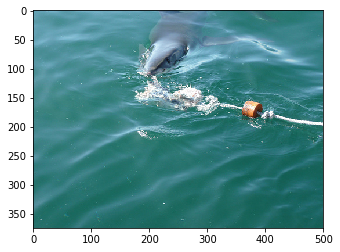

In [58]:
f, ax = plt.subplots(1,1)
ax.imshow(imread(paths[1]))
plt.show()

In [103]:
def get_short_class_name(label_i, labels_desc = np.loadtxt('/users/ruthfong/imagenet10_synsets.txt', str, delimiter='\t')
):
    return ' '.join(labels_desc[label_i].split(',')[0].split()[1:])

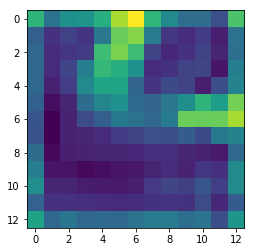

In [59]:
f, ax = plt.subplots(1,1)
ax.imshow(np.sum(acts[class_idx][1], 0))
plt.show()

In [128]:
class_i = 999
class_idx = np.where(labels == class_i)[0]
class_name = get_short_class_name(class_i)

In [125]:
max_acts = np.amax(acts[class_idx], axis=(2,3))

In [126]:
from scipy.stats import expon

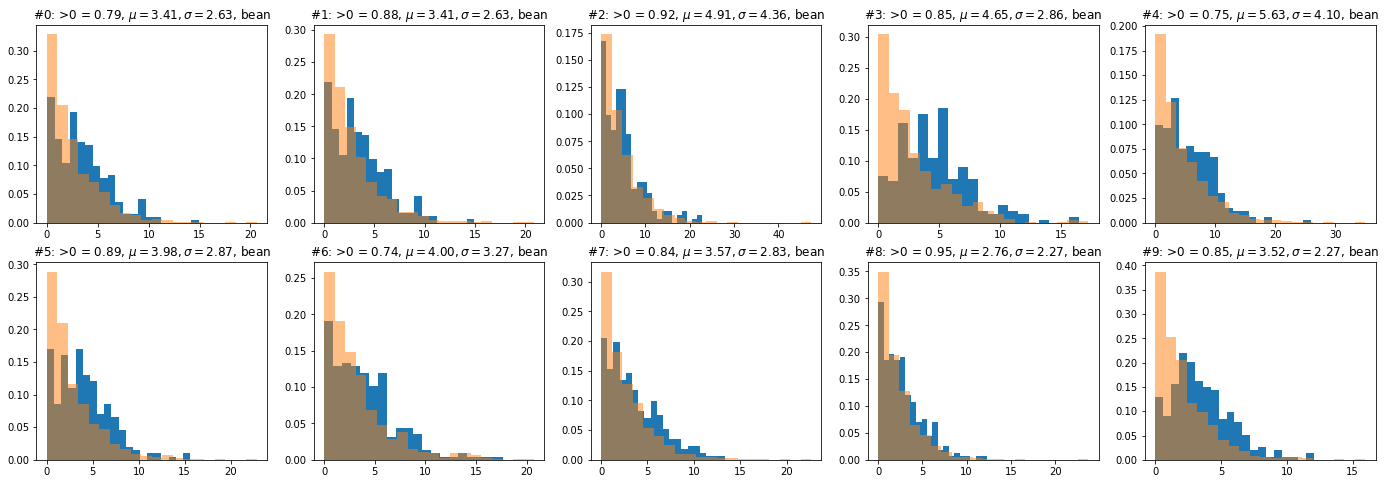

In [129]:
f, ax = plt.subplots(2,5, figsize=(24,8))
for filter_i in range(10):
    nz_idx = np.where(max_acts[:,filter_i] > 0)[0]
    ax[filter_i/5][filter_i%5].hist(max_acts[nz_idx][filter_i], bins=20, normed=True)
    mu = np.mean(max_acts[nz_idx][filter_i])
    sigma = np.std(max_acts[nz_idx][filter_i])
    prob = len(nz_idx)/float(len(max_acts[:,filter_i]))
    ax[filter_i/5][filter_i%5].hist(expon.rvs(size=1000, loc=0, scale=sigma), histtype='stepfilled', bins=20, alpha=0.5, normed=True)
    ax[filter_i/5][filter_i%5].set_title(r'#%d: >0 = %.2f, $\mu= %.2f, \sigma= %.2f$, %s' % (filter_i, prob, mu, sigma, class_name))
plt.show()

In [130]:
probs = np.zeros(blob_info.shape[1])
mus = np.zeros(blob_info.shape[1])
sigmas = np.zeros(blob_info.shape[1])

for filter_i in range(blob_info.shape[1]):
    nz_idx = np.where(max_acts[:,filter_i] > 0)[0]
    probs[filter_i] = len(nz_idx)/float(len(max_acts[:,filter_i]))
    mus[filter_i] = np.mean(max_acts[nz_idx,filter_i])
    sigmas[filter_i] = np.std(max_acts[nz_idx,filter_i])

In [131]:
probs_all[class_i] = probs
mus_all[class_i] = mus
sigmas_all[class_i] = sigmas

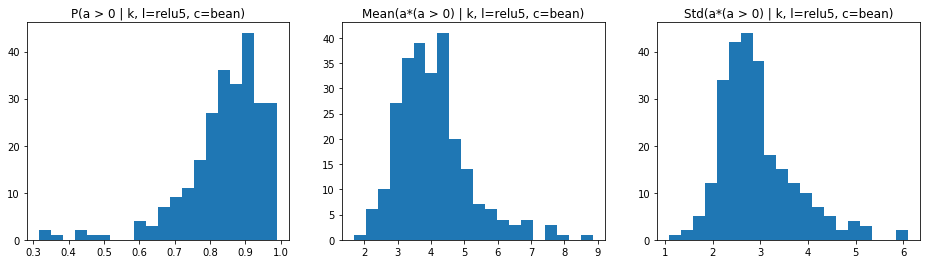

In [132]:
f, ax = plt.subplots(1,3,figsize=(16,4))
ax[0].hist(probs, bins=20)
ax[0].set_title('P(a > 0 | k, l=%s, c=%s)' % (blob_names[blob], class_name))
ax[1].hist(mus, bins=20)
ax[1].set_title('Mean(a*(a > 0) | k, l=%s, c=%s)' % (blob_names[blob], class_name))
ax[2].hist(sigmas, bins=20)
ax[2].set_title('Std(a*(a > 0) | k, l=%s, c=%s)' % (blob_names[blob], class_name))
plt.show()

In [155]:
from sklearn.decomposition import PCA

n_components = 10

pca = PCA(n_components = n_components)
pca_results = pca.fit_transform(mus_all)

print 'Explained variation per principal component: {}'.format(pca.explained_variance_ratio_)
print 'Total amount of variation explained by %d PCs = %f' % (n_components, np.sum(pca.explained_variance_ratio_))

Explained variation per principal component: [ 0.18564161  0.15039798  0.08631575  0.0579278   0.05015025  0.03841558
  0.0380686   0.03404947  0.02369807  0.02175673]
Total amount of variation explained by 10 PCs = 0.686422


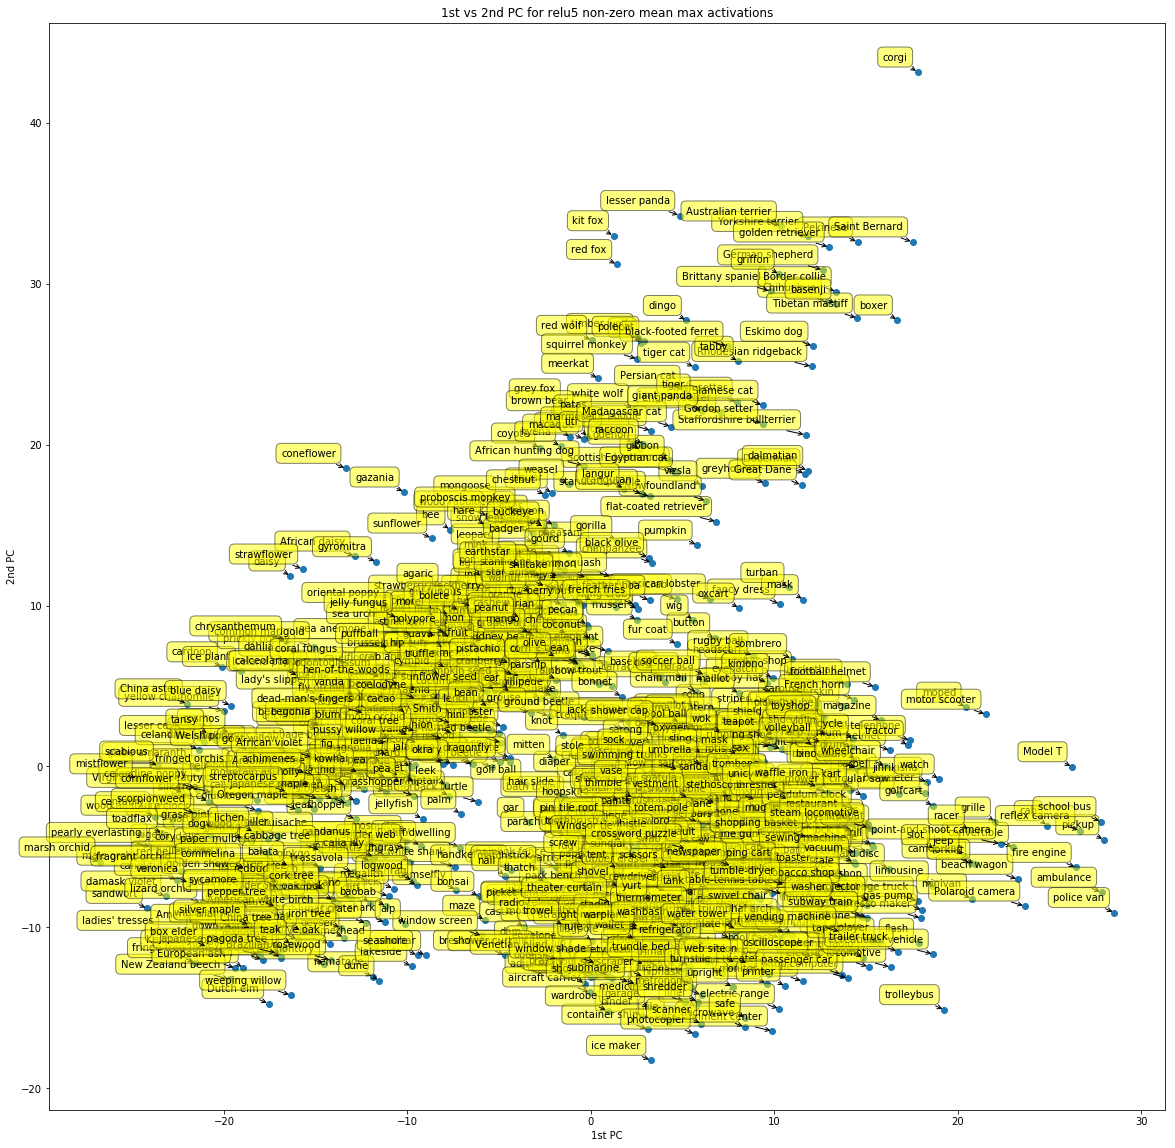

In [157]:
f, ax = plt.subplots(1,1, figsize=(20,20))

ax.scatter(
    pca_results[:,0], pca_results[:, 1], marker='o',
    cmap=plt.get_cmap('Spectral'))

for i, x, y in zip(range(1000), pca_results[:,0], pca_results[:,1]):
    plt.annotate(
        get_short_class_name(i),
        xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_title('1st vs 2nd PC for %s non-zero mean max activations' % blob_names[blob])
plt.show()

In [158]:
from sklearn.cluster import KMeans

n = 50
kmeans = KMeans(n_clusters=n).fit(mus_all)
print 'K-Means with N = %d clusters' % n
for i in range(n):
    print i, [get_short_class_name(j) for j in np.where(kmeans.labels_ == i)[0]]

K-Means with N = 50 clusters
0 ['acoustic guitar', 'backpack', 'bag', 'barber chair', 'bolo tie', 'boot', 'breastplate', 'canteen', 'car mirror', 'corkscrew', 'cuirass', 'drill', 'dumbbell', 'earphone', 'electric guitar', 'gasmask', 'hand blower', 'holster', 'knee pad', 'lipstick', 'Loafer', 'mailbag', 'microphone', 'mouse', 'optical telescope', 'padlock', 'pencil sharpener', 'revolver', 'sewing machine', 'shin guard', 'stethoscope', 'swivel chair', 'toaster', 'vacuum']
1 ['harvestman', 'black and gold garden spider', 'barn spider', 'garden spider', 'black widow', 'tarantula', 'wolf spider', 'tick', 'mite', 'centipede', 'spiny lobster', 'tiger beetle', 'ground beetle', 'long-horned beetle', 'leaf beetle', 'weevil', 'fly', 'mosquito', 'bee', 'ant', 'cricket', 'cockroach', 'cicada', 'mayfly', 'dragonfly', 'nymphalid', 'moth', 'spider web', 'star anise', 'pussy willow']
2 ['brick', 'broom', 'chainlink fence', 'chest', 'comb', 'dishrag', 'doormat', 'hamper', 'handkerchief', 'lampshade', 'm

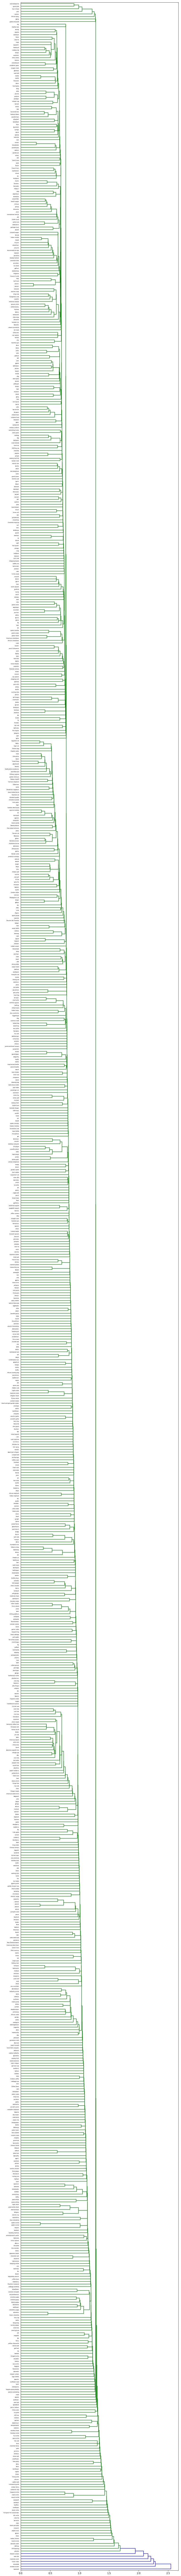

In [148]:
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(probs_all)
f, ax = plt.subplots(figsize=(12,200))
dn = dendrogram(Z, ax=ax, labels=[get_short_class_name(j) for j in range(1000)], orientation='right')
#dn = dendrogram(Z,p=100,truncate_mode='level', ax=ax, labels=[get_short_class_name(j) for j in range(1000)], orientation='right')
#plt.xticks(range(50), label_names[dn['leaves'][:-1]])

In [ ]:
print distances[label_i]
print label_names[indices[label_i]]